In [1]:
# Package imports 
import numpy as np 
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class BlackScholes:
    
    def __init__(self, S, K, T, r, sigma, t = 0):
        """ Constructor method initialises underlying model parameters
        
        Args:
            S (float): The Current Stock Price of underlying asset on which option is written.
            K (float): The Strike Price i.e. price at which option holder has write to call or put the underlying asset.
            T (int): Time remaining until options expiration date. For simplicity we express in years.
            t (int): Current time when option price is calculated. Defaults to 0.
            r (float): Risk-Free Interest Rate i.e. annualised interest rate.
            sigma (float): Volatility i.e. standard deviation of stock's returns
        """
        self.S = S # Current stock price
        self.K = K # Strike price
        self.T = T # Time to maturity
        self.t = t # Current time
        self.r = r # Risk-free Interest rate
        self.sigma = sigma # Volatility
        
        self.calculate_intermediates() # Initialises d1 and d2
    
    def calculate_intermediates(self):
        """ Function calculates d1 and d2 which are intermediate calculations in the Black-Scholes formula."""
        # d1 represents z-score for stock price adjusted for time value and volatility
        self.d1 = (np.log(self.S/self.K) + (self.r + (self.sigma**2)/2)*self.T)/(self.sigma*np.sqrt(self.T))
        # d2 represents d1 adjusted for volatility term e.g. d1 shifted by one std
        self.d2 = self.d1 - (self.sigma * np.sqrt(self.T))
        
    def update(self, **kwargs):
        """ Function allows us to dynamically update model parameters and recalculate d1 and d2 without re-initialisation"""
        
        # Checks for updated parameters and updates them in object
        if 'S' in kwargs:
            self.S = kwargs['S']
        if 'K' in kwargs:
            self.K = kwargs['K']
        if 'T' in kwargs:
            self.T = kwargs['T']
        if 'r' in kwargs:
            self.r = kwargs['r']
        if 'sigma' in kwargs:
            self.sigma = kwargs['sigma']

        # Uses updated parameters to re-calculate the intermediates for put and call option calculation
        self.calculate_intermediates()
        
    def call(self):
        """ Calculates fair price of call option e.g. right to buy asset at strike price"""
        return (self.S * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2))
        
    def put(self):
        """ Calculates fair price of put options e.g. right to sell asset at strike price"""
        return (self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2) - self.S * norm.cdf(-self.d1))

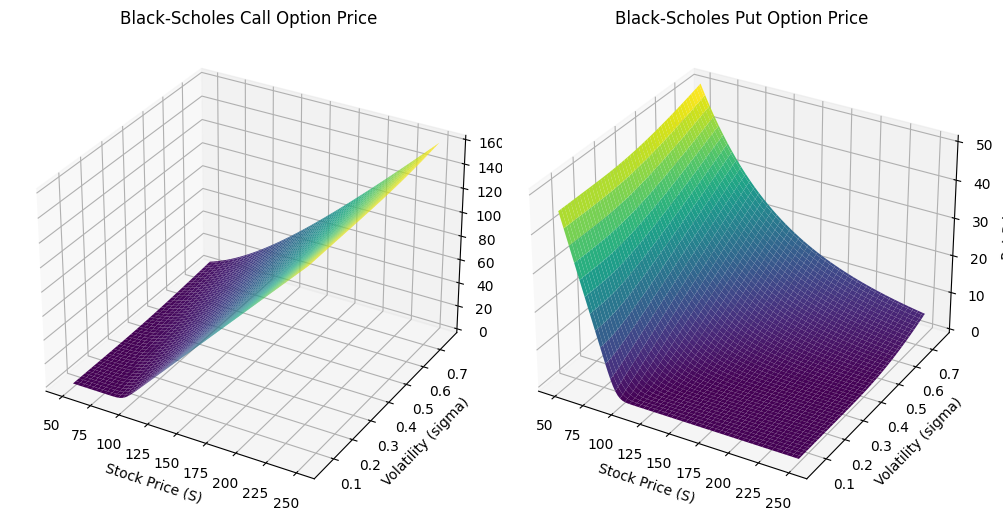

In [4]:
# Lets make some basic BS model visualisations using arbitrary ranges of stock price and volatility

# Initialising model parameters and results arrays
S_values = np.linspace(50, 250, 100)
sigma_values = np.linspace(0.05, 0.75, 100)
call_prices = np.zeros((len(S_values), len(sigma_values)))
put_prices = np.zeros((len(S_values), len(sigma_values)))
K = 100  
T = 1   
r = 0.05

# Loop through parameter combinations and computing option pricings
for i, S in enumerate(S_values):
    for j, sigma in enumerate(sigma_values):
        
        # Initialise BS model for current parameter combination
        bs = BlackScholes(S, K, T, r, sigma)
        
        # Calculating call and put prices
        call_prices[i, j] = bs.call()
        put_prices[i, j] = bs.put()

# Boilerplate plotting code....
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121, projection = '3d')
S_grid, sigma_grid = np.meshgrid(S_values, sigma_values)
ax1.plot_surface(S_grid, sigma_grid, call_prices.T, cmap = 'viridis')
ax1.set_xlabel('Stock Price (S)')
ax1.set_ylabel('Volatility (sigma)')
ax1.set_zlabel('Call Price')
ax1.set_title('Black-Scholes Call Option Price')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(S_grid, sigma_grid, put_prices.T, cmap='viridis')
ax2.set_xlabel('Stock Price (S)')
ax2.set_ylabel('Volatility (sigma)')
ax2.set_zlabel('Put Price')
ax2.set_title('Black-Scholes Put Option Price')

plt.tight_layout()
plt.show()

In [5]:
class Greeks:
    
    def __init__(self, model):
        """ Constructor method initialises Greeks class for input model"""
        self.model = model
    
    def Delta(self, type = 'call'):
        """ Delta measures the sensitivity of an options price w.r.t. price of underlying asset"""
        if type == 'put':
            return norm.cdf(self.model.d1) - 1
        elif type == 'call':
            return norm.cdf(self.model.d1)
        
    def Gamma(self):
        """ Gamma measures the sensitivity of Delta w.r.t. changes in price of underlying asset"""
        return norm.pdf(self.model.d1) / (self.model.S * self.model.sigma * np.sqrt(self.model.T))
        
    def Vega(self):
        """ Vega measures the sensitivity of options price w.r.t. changes in volatility of underlying asset"""
        return self.model.S * norm.pdf(self.model.d1) * np.sqrt(self.model.T)
        
    def Theta(self, type = 'call'):
        """ Theta measures the sensitivity of an options price w.r.t passage of time"""
        term1 = -(self.model.S * norm.pdf(self.model.d1) * self.model.sigma) / (2 * np.sqrt(self.model.T))
        if type == 'put':
            term2 = self.model.r * self.model.K * np.exp(-self.model.r * self.model.T) * norm.cdf(-self.model.d2)
            return term1 + term2
        elif type == 'call':
            term2 = self.model.r * self.model.K * np.exp(-self.model.r * self.model.T) * norm.cdf(self.model.d2)
            return term1 - term2
        
    def Rho(self, type = 'call'):
        """ Rho measures the sensitivty of an options price w.r.t. changes in interest-free rate"""
        if type == 'put':
            return -self.model.K * self.model.T * np.exp(-self.model.r * self.model.T) * norm.cdf(-self.model.d2)
        elif type == 'call':
            return self.model.K * self.model.T * np.exp(-self.model.r * self.model.T) * norm.cdf(self.model.d2)

In [10]:
# Example standalone usage of objects to find greek

# Initialise BS model with chosen parameters and print fair call and put price
S = 50
K = 100  
T = 1   
r = 0.05
sigma = 0.2
bs = BlackScholes(S, K, T, r, sigma)
print('Call: ', bs.call(), 'Put: ', bs.put())

# Initialise Greeks object with BS model
greeks = Greeks(bs)

# For example lets calculate Rho for current model instance
print('Rho Call: ', greeks.Rho('call'), 'Rho Put: ', greeks.Rho('put'))

Call:  0.0023994175533097323 Put:  45.12534186762472
Rho Call:  0.04347221264394784 Rho Put:  -95.07947023742746


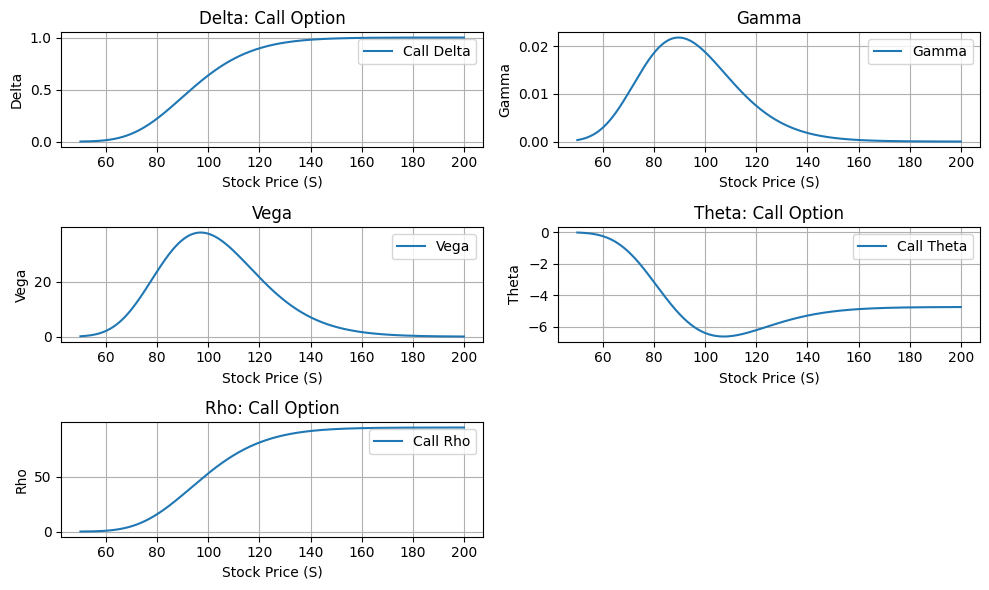

In [11]:
# There are many way we can visualise the greeks in order to inspect call and put pricing behaviour 
# To start lets look at simple case of greeks as a function of different underlying stock price for call options

# Initialising parameters and results arrays
S_values = np.linspace(50, 200, 1000)
K = 100
T = 1
r = 0.05
sigma = 0.2
delta_values = []
gamma_values = []
vega_values = []
theta_values = []
rho_values = []

# Loop through S values and compute greeks
for i, S in enumerate(S_values):
        
        # Initialise BS model and greeks for current parameter combination
        bs = BlackScholes(S, K, T, r, sigma)
        greeks = Greeks(bs)
        
        delta_values.append(greeks.Delta('call'))
        gamma_values.append(greeks.Gamma())
        vega_values.append(greeks.Vega())
        theta_values.append(greeks.Theta('call'))
        rho_values.append(greeks.Rho('call'))

# Boilerplate plotting code...
plt.figure(figsize=(10, 6))

plt.subplot(3, 2, 1)
plt.plot(S_values, delta_values, label = 'Call Delta')
plt.title('Delta: Call Option')
plt.xlabel('Stock Price (S)')
plt.ylabel('Delta')
plt.grid(True)
plt.legend()

# Gamma
plt.subplot(3, 2, 2)
plt.plot(S_values, gamma_values, label = 'Gamma')
plt.title('Gamma')
plt.xlabel('Stock Price (S)')
plt.ylabel('Gamma')
plt.grid(True)
plt.legend()

# Vega
plt.subplot(3, 2, 3)
plt.plot(S_values, vega_values, label = 'Vega')
plt.title('Vega')
plt.xlabel('Stock Price (S)')
plt.ylabel('Vega')
plt.grid(True)
plt.legend()

# Theta
plt.subplot(3, 2, 4)
plt.plot(S_values, theta_values, label = 'Call Theta')
plt.title('Theta: Call Option')
plt.xlabel('Stock Price (S)')
plt.ylabel('Theta')
plt.grid(True)
plt.legend()

# Rho
plt.subplot(3, 2, 5)
plt.plot(S_values, rho_values, label = 'Call Rho')
plt.title('Rho: Call Option')
plt.xlabel('Stock Price (S)')
plt.ylabel('Rho')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()